In [1]:
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import stats
from scipy.ndimage import gaussian_filter
import pandas as pd
from tabulate import tabulate
import xarray as xr
import dask

import seaborn as sns

import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib import animation
from matplotlib import transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as imag
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as mticker
import types


import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import csv
import pandas as pd
import os

from mpl_toolkits.basemap import Basemap
bm = Basemap()

import types
def bottom_offset(self, bboxes, bboxes2):
    bottom = self.axes.bbox.ymin
    self.offsetText.set(va="top", ha="left")
    self.offsetText.set_position(
            (0, bottom - self.OFFSETTEXTPAD * self.figure.dpi / 72.0))


def register_bottom_offset(axis, func):
    axis._update_offset_text_position = types.MethodType(func, axis)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [2]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [3]:
path_to_file = '../Preprocessed_Data/Paper_Annual/full_physics_essentials_valid_month02_targets.nc'
real_ds = xr.open_dataset(path_to_file)

path_to_file = '../Models/Annual_Softmax.nc'
Softmax_ds = xr.open_dataset(path_to_file)

path_to_file = '../Models/Annual_Softplus.nc'
Softplus_ds = xr.open_dataset(path_to_file)

path_to_file = '../Models/Annual_Exponential.nc'
Exponential_ds = xr.open_dataset(path_to_file)

path_to_file = '../Models/Annual_Linear_Baseline.nc'
Linear_Baseline_ds = xr.open_dataset(path_to_file)

#path_to_file = 'Models/Paper_Full_2018.nc'
#predict_ds = xr.open_dataset(path_to_file)

In [4]:
real_ds.variables

Frozen(OrderedDict([('target_lev', <xarray.IndexVariable 'target_lev' (target_lev: 65)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])), ('time', <xarray.Variable (sample: 472449024)>
[472449024 values with dtype=int64]), ('lat', <xarray.Variable (sample: 472449024)>
[472449024 values with dtype=float64]), ('lon', <xarray.Variable (sample: 472449024)>
[472449024 values with dtype=float64]), ('targets', <xarray.Variable (sample: 472449024, target_lev: 65)>
[30709186560 values with dtype=float32]), ('target_names', <xarray.Variable (target_lev: 65)>
array(['PTTEND_lev00', 'PTTEND_lev01', 'PTTEND_lev02', 'PTTEND_lev03',
       'PTTEND_lev04', 'PTTEND_lev05', 'PTTEND_lev06', 'PTTEND_lev07',
       'PTTEND_lev08', 'PTTEND_lev09', 'PTTEND_lev10', 'PTTEND

In [5]:
print(np.squeeze(real_ds.targets[:,-1].values).shape)

(472449024,)


In [6]:
precip_SPCAM5_ds = np.squeeze(real_ds.targets[:,-1].values)
precip_Softmax_ds = Softmax_ds.Prediction.values
precip_Softplus_ds = Softplus_ds.Prediction.values
precip_Exponential_ds = Exponential_ds.Prediction.values
precip_Linear_Baseline_ds = Linear_Baseline_ds.Prediction.values

times = real_ds.time.values

lats = np.linspace(-90.0, 90.0, 96)
lons = np.linspace(0.0, 357.5, 144)

Xvar, Yvar = np.meshgrid(lons, lats)

x = 144
y = 96
z = 30
t = int(len(precip_SPCAM5_ds)/(x*y))
print(t)

34176


In [7]:
precip_SPCAM5 = np.zeros(shape=(t, y, x))
precip_Softmax = np.zeros(shape=(t, y, x))
precip_Softplus = np.zeros(shape=(t, y, x))
precip_Exponential = np.zeros(shape=(t, y, x))
precip_Linear_Baseline = np.zeros(shape=(t, y, x))
count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            precip_SPCAM5[i, j, k] = precip_SPCAM5_ds[count]*86400000.
            precip_Softmax[i, j, k] = precip_Softmax_ds[count]*86400000.
            precip_Softplus[i, j, k] = precip_Softplus_ds[count]*86400000.
            precip_Exponential[i, j, k] = precip_Exponential_ds[count]*86400000.
            precip_Linear_Baseline[i, j, k] = precip_Linear_Baseline_ds[count]*86400000.
            
            count = count + 1

In [8]:
truths = np.nanmean(precip_SPCAM5, axis = 0)

predictions_Softmax = np.nanmean(precip_Softmax, axis = 0)
predictions_Softplus = np.nanmean(precip_Softplus, axis = 0)
predictions_Exponential = np.nanmean(precip_Exponential, axis = 0)
predictions_Linear_Baseline = np.nanmean(precip_Linear_Baseline, axis = 0)

diff_Softmax = predictions_Softmax-truths
diff_Softplus = predictions_Softplus-truths
diff_Exponential = predictions_Exponential-truths
diff_Linear_Baseline = predictions_Linear_Baseline-truths

precip_levels = np.linspace(-2,26,15)
diff_levels = np.linspace(-2.5,2.5,26)

In [12]:
print(diff_Softplus)

[[ 0.07557671  0.07535357  0.07558828 ...  0.07539537  0.07603418
   0.07555782]
 [ 0.09448119  0.09506826  0.09523965 ...  0.09181362  0.09381369
   0.09804009]
 [ 0.07179259  0.07312075  0.07478968 ...  0.05821369  0.06013231
   0.06435879]
 ...
 [-0.02075998  0.00267142 -0.01540346 ... -0.04764942 -0.02561673
  -0.0301006 ]
 [-0.00385818  0.00097117  0.00394902 ... -0.02487997 -0.00902576
  -0.00873896]
 [ 0.10278506  0.11235249  0.10672165 ...  0.10855557  0.1055841
   0.11177321]]


In [22]:
np.save("/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Paper_Annual_Precip_Error_Softmax.npy", diff_Softmax)
np.save("/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Paper_Annual_Precip_Error_Softplus.npy", diff_Softplus)
np.save("/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Paper_Annual_Precip_Error_Exponential.npy", diff_Exponential)
np.save("/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Paper_Annual_Precip_Error_Linear_Baseline.npy", diff_Linear_Baseline)

NameError: name 'diff' is not defined

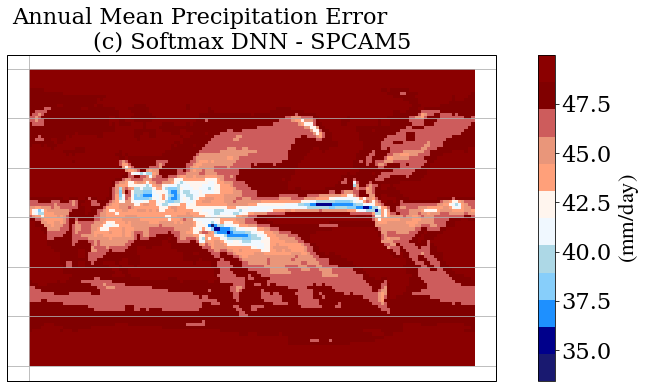

In [20]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(15,6)

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N, clip=True)
#contour_plot = ax.contourf(Xvar, Yvar, diff_Softmax,diff_levels,cmap=cmap, vmin =-2.5, vmax=2.5, transform=ccrs.PlateCarree(central_longitude=180))
contour_plot = ax.pcolormesh(diff_Softmax,cmap=cmap)
#fig.subplots_adjust(right=0.8)
#cbaxes = fig.add_axes([0.82, 0.12, 0.05, 0.23])
cbar = plt.colorbar(contour_plot, label=r'$\left(\mathrm{mm/day}\right)$') 
ax.set_title('(c) Softmax DNN - SPCAM5', fontsize = fz)
ax.coastlines(linewidth=2.0,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.subplots_adjust(hspace=0.12, wspace=0)
plt.suptitle("Annual Mean Precipitation Error", y=0.99, x=0.47, fontsize = fz)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Annual_Precip_Error_Softmax.npy", diff_Softmax)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["mediumblue","blue", "deepskyblue", "aquamarine", "lightgreen","limegreen","greenyellow","yellow","gold","orange","orangered","red","mediumvioletred","purple"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N) 
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(15,6)

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)
contour_plot = ax.contourf(Xvar, Yvar, diff_Softplus,diff_levels,cmap=cmap, vmin =-2.5, vmax=2.5, transform=ccrs.PlateCarree())
#fig.subplots_adjust(right=0.8)
#cbaxes = fig.add_axes([0.82, 0.12, 0.05, 0.23])
cbar = plt.colorbar(contour_plot, label=r'$\left(\mathrm{mm/day}\right)$') 
ax.set_title('(c) Softmax DNN - SPCAM5', fontsize = fz)
ax.coastlines(linewidth=2.0,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.subplots_adjust(hspace=0.12, wspace=0)
plt.suptitle("Annual Mean Precipitation Error", y=0.99, x=0.47, fontsize = fz)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Annual_Precip_Error_Softplus.npy", diff_Softplus)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["mediumblue","blue", "deepskyblue", "aquamarine", "lightgreen","limegreen","greenyellow","yellow","gold","orange","orangered","red","mediumvioletred","purple"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N) 
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(15,6)

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)
contour_plot = ax.contourf(Xvar, Yvar, diff_Exponential,diff_levels,cmap=cmap, vmin =-2.5, vmax=2.5, transform=ccrs.PlateCarree())
#fig.subplots_adjust(right=0.8)
#cbaxes = fig.add_axes([0.82, 0.12, 0.05, 0.23])
cbar = plt.colorbar(contour_plot, label=r'$\left(\mathrm{mm/day}\right)$') 
ax.set_title('(c) Exponential DNN - SPCAM5', fontsize = fz)
ax.coastlines(linewidth=2.0,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.subplots_adjust(hspace=0.12, wspace=0)
plt.suptitle("Annual Mean Precipitation Error", y=0.99, x=0.47, fontsize = fz)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Annual_Precip_Error_Exponential.npy", diff_Exponential)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["mediumblue","blue", "deepskyblue", "aquamarine", "lightgreen","limegreen","greenyellow","yellow","gold","orange","orangered","red","mediumvioletred","purple"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N) 
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(15,6)

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)
contour_plot = ax.contourf(Xvar, Yvar, diff_Linear_Baseline,diff_levels,cmap=cmap, vmin =-2.5, vmax=2.5, transform=ccrs.PlateCarree())
#fig.subplots_adjust(right=0.8)
#cbaxes = fig.add_axes([0.82, 0.12, 0.05, 0.23])
cbar = plt.colorbar(contour_plot, label=r'$\left(\mathrm{mm/day}\right)$') 
ax.set_title('(c) Linear Baseline DNN - SPCAM5', fontsize = fz)
ax.coastlines(linewidth=2.0,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.subplots_adjust(hspace=0.12, wspace=0)
plt.suptitle("Annual Mean Precipitation Error", y=0.99, x=0.47, fontsize = fz)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Annual_Precip_Error_Linear_Baseline.npy", diff)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["mediumblue","blue", "deepskyblue", "aquamarine", "lightgreen","limegreen","greenyellow","yellow","gold","orange","orangered","red","mediumvioletred","purple"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N) 
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(15,6)

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)
contour_plot = ax.contourf(Xvar, Yvar, diff,diff_levels,cmap=cmap, vmin =-2.5, vmax=2.5, transform=ccrs.PlateCarree())
#fig.subplots_adjust(right=0.8)
#cbaxes = fig.add_axes([0.82, 0.12, 0.05, 0.23])
cbar = plt.colorbar(contour_plot, label=r'$\left(\mathrm{mm/day}\right)$') 
ax.set_title('(c) DNN - SPCAM5', fontsize = fz)
ax.coastlines(linewidth=2.0,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.subplots_adjust(hspace=0.12, wspace=0)
plt.suptitle("Annual Mean Precipitation Error", y=0.99, x=0.47, fontsize = fz)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Annual_Precip_Error.npy", diff)

In [ ]:
path_to_file = '/fast/gmooers/Models/Paper_Full_2018_Primative.nc'
primative_ds = xr.open_dataset(path_to_file)
primative_dnn_ds = primative_ds.Prediction.values*86400000.

In [ ]:
primative_dnn = np.zeros(shape=(t, y, x))

count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = primative_dnn_ds[count]
            primative_dnn[i, j, k] = A
            count = count + 1

In [ ]:
precip_cam_ds = precip_cam_ds*86400000.

In [ ]:
D = precip_DNN.ravel()
PD = primative_dnn.ravel()
T = precip_spcam5.ravel()
C = precip_cam_ds.ravel()

In [ ]:
max_values = [np.nanmax(D), np.nanmax(T), np.nanmax(C)]
min_values = [np.nanmin(D),  np.nanmin(T),  np.nanmin(C)]
m = min(min_values)
M = max(max_values)

In [ ]:
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_SPCAM5_Precip_Linear_Baseline.npy",D)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_SPCAM5_Precip_Exponential.npy",PD)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_SPCAM5_Precip_Softmax.npy",T)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_SPCAM5_Softplus.npy",C)

In [ ]:
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_SPCAM5_Precip_Prediction.npy",D)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_SPCAM5_Precip_Primative_Prediction.npy",PD)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_SPCAM5_Precip_Truth.npy",T)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_CAM5_PRECIP.npy",C)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Precip_Max_Scalar.npy",m)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Precip_Min_Scalar.npy",M)

In [ ]:
ocean_DNN = np.zeros(shape=(t, y, x))
ocean_Primative_DNN = np.zeros(shape=(t, y, x))
ocean_SPCAM5 = np.zeros(shape=(t, y, x))
ocean_CAM5 = np.zeros(shape=(len(precip_cam_ds),y, x))

ocean_DNN[:,:,:] = np.nan
ocean_SPCAM5[:,:,:] = np.nan
ocean_CAM5[:,:,:] = np.nan


for i in range(len(ocean_DNN[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(ocean_DNN[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == False:
            ocean_DNN[:, j, i] = precip_DNN[:, j, i]
            ocean_Primative_DNN[:,j,i] = primative_dnn[:,j,i] 
            ocean_SPCAM5[:, j, i] =  precip_spcam5[:, j, i]
            
for i in range(len(ocean_CAM5[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(ocean_CAM5[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == False:
            ocean_CAM5[:, j, i] = precip_cam_ds[:, j, i]
        

print('ocean masks applied')

In [ ]:
land_DNN = np.zeros(shape=(t, y, x))
land_Primiative_DNN = np.zeros(shape=(t, y, x))
land_SPCAM5 = np.zeros(shape=(t, y, x))
land_CAM5 = np.zeros(shape=(len(precip_cam_ds),y, x))

land_DNN[:,:,:] = np.nan
land_SPCAM5[:,:,:] = np.nan
land_CAM5[:,:,:] = np.nan


for i in range(len(land_DNN[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(land_DNN[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == True:
            land_DNN[:, j, i] = precip_DNN[:, j, i]
            land_Primiative_DNN[:,j,i] = primative_dnn[:,j,i]
            land_SPCAM5[:, j, i] = precip_spcam5[:, j, i]
            
for i in range(len(land_CAM5[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(land_CAM5[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == True:
            land_CAM5[:, j, i] = precip_cam_ds[:, j, i]
        

print('land masks applied')

In [ ]:
C_ocean = ocean_CAM5.ravel()
C_land = land_CAM5.ravel()

D_ocean = ocean_DNN.ravel()
D_land = land_DNN.ravel()

DP_ocean = ocean_Primative_DNN.ravel()
DP_land = land_Primiative_DNN.ravel()

T_ocean = ocean_SPCAM5.ravel()
T_land = land_SPCAM5.ravel()

In [ ]:
ocean_max_values = [np.nanmax(D_ocean), np.nanmax(T_ocean), np.nanmax(C_ocean)]
ocean_min_values = [np.nanmin(D_ocean),  np.nanmin(T_ocean),  np.nanmin(C_ocean)]
m_ocean = min(ocean_min_values)
M_ocean = max(ocean_max_values)
land_max_values = [np.nanmax(D_land), np.nanmax(T_land), np.nanmax(C_land)]
land_min_values = [np.nanmin(D_land),  np.nanmin(T_land),  np.nanmin(C_land)]
m_land = min(land_min_values)
M_land = max(land_max_values)

In [ ]:
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_SPCAM5_Precip_Prediction.npy",D_ocean)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_SPCAM5_Precip_Primative_Prediction.npy",DP_ocean)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_SPCAM5_Prepip_Truth.npy",T_ocean)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_CAM5_PRECIP.npy",C_ocean)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_Precip_Max_Scalar.npy",m_ocean)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_Precip_Min_Scalar.npy",M_ocean)

#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_SPCAM5_Precip_Prediction.npy",D_land)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_SPCAM5_Precip_Primative_Prediction.npy",DP_land)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_SPCAM5_Prepip_Truth.npy",T_land)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_CAM5_PRECIP.npy",C_land)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_Precip_Max_Scalar.npy",m_land)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_Precip_Min_Scalar.npy",M_land)


print("precip data saved")

In [ ]:
def array_generator(min_val, max_val, percentage):
    listing = []
    for i in range(300):
        if i == 0:
            temp_val = min_val
            listing.append(temp_val)
        else:
            if temp_val < max_val:
                temp_val = temp_val*percentage
                listing.append(temp_val)
        
    print(len(listing))
    return np.array(listing)
#array_generator(0.03, maxi, 1.07)

In [ ]:
bins = array_generator(0.03, M, 1.03)



fig, ax = plt.subplots(3,2,figsize=(15,15))

shared_bins = np.histogram_bin_edges(D, bins=bins, range=(0, M))
freq, edges = np.histogram(D, bins = shared_bins, density=True)
bad_freq, bad_edges = np.histogram(PD, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C, bins = shared_bins, density=True)

ax[0,1].set_xscale("log")
ax[1,1].set_xscale("log")
ax[2,1].set_xscale("log")

ax[0,0].plot(edges[:-1], freq/np.sum(freq),  label = "NN", color = 'blue')
ax[0,0].plot(bad_edges[:-1], bad_freq/np.sum(bad_freq),  label = "Primative NN", color = 'blue', linestyle="--")
ax[0,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), label = "SPCAM5", color = 'green')
ax[0,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams), label = "CAM5", color = 'red')
ax[0,0].set_ylim(1e-8, 1)

ax[2,0].set_xlabel('Rate '+r'$\left(\mathrm{mm \ day^{-1}}\right)$', fontsize = fz)
ax[2,0].xaxis.set_label_coords(1.1,-0.1)
ax[1,0].set_ylabel('Probability', fontsize = fz)
ax[0,0].set_title('(a) Global PDF', fontsize = fz)
ax[1,0].set_title('(c) Ocean PDF', fontsize = fz)
ax[2,0].set_title('(e) Land PDF', fontsize = fz)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks([])
    
totals = freq*edges[:-1]
bad_totals = bad_freq*bad_edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]
    
ax[0,1].plot(edges[:-1], totals,  label = "DNN", color = 'blue')
ax[0,1].plot(bad_edges[:-1], bad_totals,  label = "Primative DNN", color = 'blue', linestyle="--")
ax[0,1].plot(edges_targ[:-1], totals_targ, label = "SPCAM5", color = 'green')
ax[0,1].plot(edges_cams[:-1], totals_cam, label = "CAM5", color = 'red')

ax[1,1].set_ylabel('Amount '+r'$\left(\mathrm{mm \ day^{-1}}\right)$', fontsize = fz)
ax[0,1].set_title('(b) Global Amount Distribution', fontsize = fz)
ax[1,1].set_title('(d) Ocean Amount Distribution', fontsize = fz)
ax[2,1].set_title('(f) Land Amount Distribution', fontsize = fz)
ax[0,0].legend(loc = 'best')

ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].set_xticks([])
ax[0,1].set_ylim(0, 0.4)

shared_bins = np.histogram_bin_edges(D_ocean, bins=bins, range=(0, M))
freq, edges = np.histogram(D_ocean, bins = shared_bins, density=True)
bad_freq, bad_edges = np.histogram(DP_ocean, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T_ocean, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C_ocean, bins = shared_bins, density=True)

ax[1,0].plot(edges[:-1], freq/np.sum(freq), color = 'blue')
ax[1,0].plot(bad_edges[:-1], bad_freq/np.sum(bad_freq), color = 'blue', linestyle="--")
ax[1,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), color = 'green')
ax[1,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams),  color = 'red')
ax[1,0].set_xticks([])
ax[1,0].set_yscale('log')
ax[1,0].set_ylim(1e-8, 1)

totals = freq*edges[:-1]
bad_totals = bad_freq*bad_edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]

ax[1,1].plot(edges[:-1], totals, color = 'blue')
ax[1,1].plot(bad_edges[:-1], bad_totals, color = 'blue', linestyle="--")
ax[1,1].plot(edges_targ[:-1], totals_targ, color = 'green')
ax[1,1].plot(edges_cams[:-1], totals_cam, color = 'red')
ax[1,1].set_xticks([])
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()
ax[1,1].set_ylim(0, 0.4)

shared_bins = np.histogram_bin_edges(D_land, bins=bins, range=(0, M))
freq, edges = np.histogram(D_land, bins = shared_bins, density=True)
bad_freq, bad_edges = np.histogram(DP_land, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T_land, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C_land, bins = shared_bins, density=True)

ax[2,0].plot(edges[:-1], freq/np.sum(freq), color = 'blue')
ax[2,0].plot(bad_edges[:-1], bad_freq/np.sum(bad_freq), color = 'blue', linestyle="--")
ax[2,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), color = 'green')
ax[2,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams),  color = 'red')
ax[2,0].set_yscale('log')
ax[2,0].set_ylim(1e-8, 1)

totals = freq*edges[:-1]
bad_totals = bad_freq*bad_edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]

ax[2,1].plot(edges[:-1], totals, color = 'blue')
ax[2,1].plot(bad_edges[:-1], bad_totals, color = 'blue', linestyle="--")
ax[2,1].plot(edges_targ[:-1], totals_targ, color = 'green')
ax[2,1].plot(edges_cams[:-1], totals_cam, color = 'red')
ax[2,1].yaxis.set_label_position("right")
ax[2,1].yaxis.tick_right()
ax[2,1].set_ylim(0, 0.4)
plt.suptitle("Precipitation", y=0.93)
plt.subplots_adjust(wspace=0.01, hspace=0.10)